In [18]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

In [113]:
#Need to specify dtype of columns for every csv column for this and every other import

#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]

roster.shape

c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136018, 13)

In [20]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365.25)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365.25)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=3)

In [21]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [22]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)

In [23]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
#stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

stats = stats.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

#stats = stats.groupby(['Player','season', 'league', 'player_id'], as_index=False).sum()

In [24]:
#joining league and stat data to the dataframe


roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                             'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 
                             'playoff_+/-', 'team_id', 'team', 'league']], 
                            on = ['player_id', 'season', 'team_id', 'team'])

In [25]:


roster = roster.groupby(['Player','Age', 'Position', 'Birthdate', 'HT', 'WT', 
                         'season', 'season_start', 'draft_cutoff', 'draft_cutoff_age',
                         'draft_year', 'player_id', 'league'], as_index=False).sum()

In [26]:
roster[roster['Player'] == 'Joseph Veleno']

,Player,Age,Position,Birthdate,HT,WT,season,season_start,draft_cutoff,draft_cutoff_age,draft_year,player_id,league,team_id,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-
52609,Joseph Veleno,15.67,C,2000-01-13,"6'1""",194,2016,2015-09-15,2016-09-15,16.674,-2,271713,QMJHL,2065,62,13,30,43,21,17,6,1,7,8,-10
52610,Joseph Veleno,16.67,C,2000-01-13,"6'1""",194,2017,2016-09-15,2017-09-15,17.673,-1,271713,QMJHL,4130,49,16,28,44,20,18,8,3,11,4,14
52611,Joseph Veleno,17.67,C,2000-01-13,"6'1""",194,2018,2017-09-15,2018-09-15,18.672,0,271713,QMJHL,2948,64,22,57,79,48,10,5,6,11,10,-1


In [27]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [28]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [29]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [30]:
roster.head()

,Player,Age,Position,Birthdate,HT,WT,season,season_start,draft_cutoff,draft_cutoff_age,draft_year,player_id,league,team_id,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP
0,A.J. Bozoian,22.38,D,1982-04-29,5.92,190,2005,2004-09-15,2005-09-15,23.381,5,17933,NCAA,791,4,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0,0,0
1,A.J. Degenhardt,20.05,C,1982-08-28,5.83,183,2003,2002-09-15,2003-09-15,21.049,3,81439,NCAA,452,39,3,9,12,14,0,0,0,0,0,0,0.25,0.75,0.31,0.0,0,0,0
2,A.J. Degenhardt,21.05,C,1982-08-28,5.83,183,2004,2003-09-15,2004-09-15,22.051,4,81439,NCAA,452,43,8,8,16,14,0,0,0,0,0,0,0.50,0.50,0.37,0.0,0,0,0
3,A.J. Degenhardt,22.05,C,1982-08-28,5.83,183,2005,2004-09-15,2005-09-15,23.050,5,81439,NCAA,452,36,4,1,5,8,0,0,0,0,0,0,0.80,0.20,0.14,0.0,0,0,0
4,A.J. Degenhardt,23.05,C,1982-08-28,5.83,183,2006,2005-09-15,2006-09-15,24.049,6,81439,NCAA,452,30,3,3,6,10,0,0,0,0,0,0,0.50,0.50,0.20,0.0,0,0,0


In [31]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [32]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [33]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


In [34]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


In [35]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[(roster['draft_year'] == 0)]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [36]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [37]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [38]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [39]:
draft_year_df = pd.get_dummies(draft_year_df, columns=['league'])

In [40]:
draft_year_df.head()

,Player,Age,Position,Birthdate,HT,WT,season,season_start,draft_cutoff,draft_cutoff_age,draft_year,player_id,team_id,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
63,A.J. Thelen,17.51,D,1986-03-11,6.25,212,2004,2003-09-15,2004-09-15,18.516,0,11595,1157,41,11,18,29,50,0,0,0,0,0,0,0.38,0.62,0.71,0.0,0.0,0,0.0,0.690809,0.000000,0,0,0,0,0,1,0,0,0,0,0,0
146,Aaron Borejko,17.47,D,1991-03-28,5.92,205,2009,2008-09-15,2009-09-15,18.470,0,24289,451,50,1,5,6,28,11,0,0,0,2,0,0.17,0.83,0.12,0.0,0.0,0,0.0,0.117011,0.000000,0,0,0,0,0,0,0,0,0,0,0,1
171,Aaron Dawson,17.51,D,1985-03-11,6.42,218,2003,2002-09-15,2003-09-15,18.513,0,38693,875,65,1,8,9,76,7,0,0,0,8,-2,0.11,0.89,0.14,0.0,0.0,0,0.0,0.136216,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
182,Aaron Ekblad,17.60,D,1996-02-07,6.33,216,2014,2013-09-15,2014-09-15,18.604,0,49042,865,58,23,30,53,91,9,2,4,6,14,-4,0.43,0.57,0.91,309.0,53.0,81,134.0,0.881062,0.433657,0,0,0,0,0,0,1,0,0,0,0,0
223,Aaron Harstad,17.39,D,1992-04-27,6.17,198,2010,2009-09-15,2010-09-15,18.385,0,37787,901,47,2,6,8,61,11,0,3,3,9,1,0.25,0.75,0.17,0.0,0.0,0,0.0,0.166486,0.000000,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
#split draft_year_df into one for forwards and defensemen
draft_2018_df = draft_year_df[draft_year_df['season'] == 2018]
draft_year_df = draft_year_df[draft_year_df['season']<2018]
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [42]:
draft_2018_df.head()

,Player,Age,Position,Birthdate,HT,WT,season,season_start,draft_cutoff,draft_cutoff_age,draft_year,player_id,team_id,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
557,Adam Boqvist,17.08,D,2000-08-15,5.92,170,2018,2017-09-15,2018-09-15,18.084,0,265684,13,7,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.29,0.0,0.0,0,0.0,0.288770,0.0,1,0,0,0,0,0,0,0,0,0,0,0
558,Adam Boqvist,17.08,D,2000-08-15,5.92,170,2018,2017-09-15,2018-09-15,18.084,0,265684,4,18,0,2,2,6,3,0,0,0,0,1,0.00,1.00,0.11,0.0,0.0,0,0.0,0.109534,0.0,0,0,0,0,0,0,0,0,1,0,0,0
750,Adam Gaudreau,17.72,D,1999-12-28,5.75,150,2018,2017-09-15,2018-09-15,18.716,0,469420,676,24,0,2,2,10,1,0,0,0,0,0,0.00,1.00,0.08,0.0,0.0,0,0.0,0.076947,0.0,0,0,0,0,0,0,0,1,0,0,0,0
766,Adam Ginning,17.67,D,2000-01-13,6.25,196,2018,2017-09-15,2018-09-15,18.672,0,281968,6,28,1,1,2,10,7,0,1,1,2,-2,0.50,0.50,0.07,0.0,0.0,0,0.0,0.067514,0.0,0,0,0,0,0,0,0,0,1,0,0,0
978,Adam McCormick,17.22,D,2000-06-25,5.92,181,2018,2017-09-15,2018-09-15,18.223,0,275863,893,67,7,30,37,16,5,2,1,3,0,-5,0.19,0.81,0.55,0.0,0.0,0,0.0,0.543587,0.0,0,0,0,0,0,0,0,1,0,0,0,0


In [43]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,18.0,0.000000
0.50,50.0,0.000000
0.75,62.0,0.000000
0.95,70.0,0.301034
0.96,71.0,0.357143
0.97,71.0,0.437669
0.98,72.0,0.539568
0.99,72.0,0.683810


In [44]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .99])

,GP,nhl_pts_per_gp
0.25,17.0,0.000000
0.50,46.0,0.000000
0.75,61.0,0.000000
0.99,72.0,0.476159


In [45]:
#draft_df_def['>_39_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=40), 1, 0)
#draft_df_def['>_58_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=59), 1, 0)
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)


In [46]:
draft_df_def.head()

,Player,Age,Position,Birthdate,HT,WT,season,season_start,draft_cutoff,draft_cutoff_age,draft_year,player_id,team_id,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp,>_.25_nhl_pts_gp
63,A.J. Thelen,17.51,D,1986-03-11,6.25,212,2004,2003-09-15,2004-09-15,18.516,0,11595,1157,41,11,18,29,50,0,0,0,0,0,0,0.38,0.62,0.71,0.0,0.0,0,0.0,0.690809,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0
146,Aaron Borejko,17.47,D,1991-03-28,5.92,205,2009,2008-09-15,2009-09-15,18.470,0,24289,451,50,1,5,6,28,11,0,0,0,2,0,0.17,0.83,0.12,0.0,0.0,0,0.0,0.117011,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0
171,Aaron Dawson,17.51,D,1985-03-11,6.42,218,2003,2002-09-15,2003-09-15,18.513,0,38693,875,65,1,8,9,76,7,0,0,0,8,-2,0.11,0.89,0.14,0.0,0.0,0,0.0,0.136216,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0
182,Aaron Ekblad,17.60,D,1996-02-07,6.33,216,2014,2013-09-15,2014-09-15,18.604,0,49042,865,58,23,30,53,91,9,2,4,6,14,-4,0.43,0.57,0.91,309.0,53.0,81,134.0,0.881062,0.433657,0,0,0,0,0,0,1,0,0,0,0,0,1,1
223,Aaron Harstad,17.39,D,1992-04-27,6.17,198,2010,2009-09-15,2010-09-15,18.385,0,37787,901,47,2,6,8,61,11,0,3,3,9,1,0.25,0.75,0.17,0.0,0.0,0,0.0,0.166486,0.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [47]:
draft_df_fwd.columns

Index(['Player', 'Age', 'Position', 'Birthdate', 'HT', 'WT', 'season',
       'season_start', 'draft_cutoff', 'draft_cutoff_age', 'draft_year',
       'player_id', 'team_id', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',
       'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-',
       'goals_to_points', 'assists_to_points', 'pts_per_gp', 'nhl_GP', 'nhl_G',
       'nhl_A', 'nhl_TP', 'age_adj_pts_g', 'nhl_pts_per_gp',
       'league_Allsvenskan', 'league_Extraliga', 'league_KHL', 'league_Liiga',
       'league_Mestis', 'league_NCAA', 'league_OHL', 'league_QMJHL',
       'league_SHL', 'league_USDP', 'league_USHL', 'league_WHL'],
      dtype='object')

In [29]:
draft_df_def[['GP', 'playoff_GP', 'playoff_G', 'playoff_A', 
             'playoff_TP', 'playoff_+/-',
             'goals_to_points', 'assists_to_points',
             'age_adj_pts_g', 'league_Allsvenskan', 
             'league_Extraliga','league_KHL', 'league_Liiga', 
             'league_Mestis', 'league_NCAA', 'league_OHL', 
             'league_QMJHL', 'league_SHL', 
             'league_USHL', 'league_WHL', '>_.25_nhl_pts_gp', '>_72_nhl_gp']].corr()

,GP,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_+/-,goals_to_points,assists_to_points,age_adj_pts_g,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USHL,league_WHL,>_.25_nhl_pts_gp,>_72_nhl_gp
GP,1.000000,0.498642,0.279062,0.340764,0.350458,-0.009112,0.293732,0.546783,0.388479,-0.205261,-0.158168,-0.102576,-0.105219,-0.118426,-0.024638,0.122070,0.035000,-0.173818,-0.081655,0.186929,0.105602,0.150391
playoff_GP,0.498642,1.000000,0.518231,0.658310,0.670853,0.229456,0.150797,0.246834,0.305095,-0.082110,-0.068595,-0.056451,-0.042453,-0.042678,-0.067106,0.087516,0.061259,-0.051372,-0.107415,0.064127,0.146187,0.181730
playoff_G,0.279062,0.518231,1.000000,0.632914,0.793603,0.226352,0.107703,0.104845,0.403993,-0.042342,-0.038786,-0.025108,-0.029847,-0.021084,-0.029847,0.054526,0.026509,-0.041966,-0.043174,0.024959,0.294401,0.279146
playoff_A,0.340764,0.658310,0.632914,1.000000,0.973347,0.316244,0.104655,0.142149,0.464671,-0.056165,-0.038698,-0.030377,-0.018410,-0.024497,-0.036111,0.076077,0.039921,-0.051444,-0.056987,0.012356,0.286224,0.315949
playoff_TP,0.350458,0.670853,0.793603,0.973347,1.000000,0.315575,0.114148,0.142767,0.484839,-0.056681,-0.041901,-0.031310,-0.023309,-0.025497,-0.037220,0.075938,0.039225,-0.052859,-0.057573,0.017103,0.312141,0.330982
playoff_+/-,-0.009112,0.229456,0.226352,0.316244,0.315575,1.000000,-0.007507,-0.002230,0.038117,0.010637,0.010039,0.004494,0.008007,-0.001129,0.005343,-0.003321,-0.019908,0.000204,0.035838,-0.018829,0.117407,0.059320
goals_to_points,0.293732,0.150797,0.107703,0.104655,0.114148,-0.007507,1.000000,-0.085580,0.252823,-0.070537,-0.088245,-0.041142,-0.039606,-0.033554,0.029190,0.001334,-0.002992,-0.067004,0.080580,0.030647,0.087918,0.093417
assists_to_points,0.546783,0.246834,0.104845,0.142149,0.142767,-0.002230,-0.085580,1.000000,0.384566,-0.177920,-0.147419,-0.084337,-0.095433,-0.069672,0.014161,0.106358,0.005707,-0.160614,0.014787,0.103937,0.033785,0.056588
age_adj_pts_g,0.388479,0.305095,0.403993,0.464671,0.484839,0.038117,0.252823,0.384566,1.000000,-0.102453,-0.102450,-0.061112,-0.048975,-0.027862,0.045178,0.053692,-0.014166,-0.105370,0.074129,0.028255,0.302185,0.303892
league_Allsvenskan,-0.205261,-0.082110,-0.042342,-0.056165,-0.056681,0.010637,-0.070537,-0.177920,-0.102453,1.000000,-0.023670,-0.015323,-0.018215,-0.018509,-0.018215,-0.102765,-0.101076,-0.030789,-0.081157,-0.107029,-0.016380,-0.006012


In [50]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_def['>_72_nhl_gp'], test_size=0.2
                                                   )

In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2352, 22) (2352,)
(589, 22) (589,)


In [52]:
#train the logistic regression class_weight='balanced'
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(class_weight='balanced')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.853356890459364


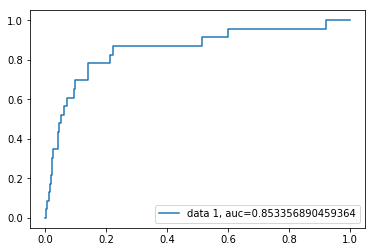

In [53]:
#calculating auc_score for plyaing more than 39 NHL games the median for Defensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict(X_test)
y_pred_proba =  logisticRegr.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[463, 103],
       [  5,  18]], dtype=int64)

In [55]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
confusion_matrix(y_test, gnb_pred)

array([[469,  97],
       [  4,  19]], dtype=int64)

0.8026962667076356


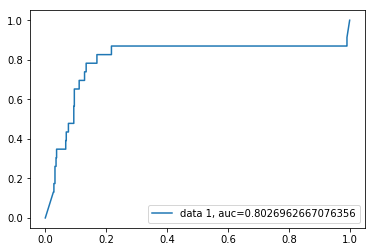

In [56]:
#naive bayes predictor
gnb_predictions = gnb.predict(X_test)
y_pred_prob_gnb =  gnb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_gnb)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
confusion_matrix(y_test, tree_pred)

array([[486,  80],
       [  8,  15]], dtype=int64)

0.8368412966661546


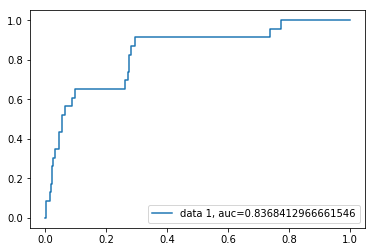

In [58]:
#random forest predictor
tree_predictions = tree.predict(X_test)
y_pred_prob_tree =  tree.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_tree)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_tree)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [59]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
confusion_matrix(y_test, dt_pred)

array([[416, 150],
       [  4,  19]], dtype=int64)

0.7990090643724075


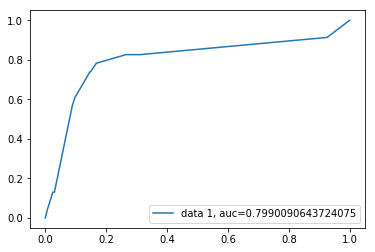

In [60]:
#Decision Tree
dt_predictions = dt.predict(X_test)
y_pred_prob_dt =  dt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_dt)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_dt)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [119]:
#calculate Decision Tree prediction probabilities
predictions = dt.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_dt'] = predictions_2018

In [120]:
predictions


array([0.93173069, 0.93173069, 0.93173069, ..., 0.        , 0.        ,
       0.88046167])

In [121]:
#calculate random forest prediction probabilities
predictions = tree.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_tree'] = predictions_2018

In [122]:
#calculate random forest prediction probabilities
predictions = gnb.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_gnb'] = predictions_2018

In [123]:
#calculate random forest prediction probabilities
predictions = logisticRegr.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logisticRegr.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_log'] = predictions_2018

Text(0.5,0,'nhl_pts_per_gp')

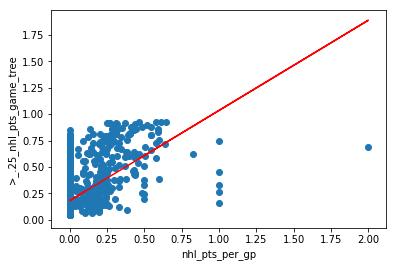

In [124]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'], deg=1)
ax.plot(draft_df_def['nhl_pts_per_gp'], fit[0] * draft_df_def['nhl_pts_per_gp'] + fit[1], color='red')
ax.scatter(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'])
plt.ylabel('>_.25_nhl_pts_game_tree')
plt.xlabel('nhl_pts_per_gp')

In [125]:
draft_2018_df_def['model_average_games'] = draft_2018_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_def = draft_2018_df_def.sort_values(['model_average'], ascending=False)


In [126]:
draft_2018_df_def[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average
96756,Nicolas Beaudin,0.990871,1.000000,0.860601,0.931731,0.945801
120697,Ty Smith,0.996535,1.000000,0.846684,0.931731,0.943737
88091,Rasmus Sandin,0.994956,1.000000,0.776034,0.931731,0.925680
87814,Evan Bouchard,0.999471,1.000000,0.770190,0.931731,0.925348
120347,Calen Addison,0.999380,1.000000,0.762696,0.931731,0.923452
96573,Noah Dobson,0.990889,1.000000,0.741689,0.931731,0.916077
103262,Bode Wilde,0.953761,0.960666,0.804797,0.931731,0.912739
87704,Ryan Merkley,0.997704,1.000000,0.714655,0.931731,0.911022
78857,Quinn Hughes,0.956222,1.000000,0.725870,0.931731,0.903456
120553,Alexander Alexeyev,0.923823,0.999954,0.731243,0.931731,0.896688


In [127]:
draft_rankings_2018 = draft_2018_df_def[['Player', 'model_average']].groupby(['Player'], as_index=False).mean().sort_values(['model_average'], ascending=False)

In [128]:
draft_rankings_2018.head(30)

,Player,model_average
147,Nicolas Beaudin,0.945801
189,Ty Smith,0.943737
61,Evan Bouchard,0.925348
28,Calen Addison,0.923452
150,Noah Dobson,0.916077
166,Ryan Merkley,0.911022
159,Quinn Hughes,0.903456
11,Alexander Alexeyev,0.896688
92,Jared McIsaac,0.880101
160,Rasmus Dahlin,0.855341


In [133]:
draft_df_def['model_average_>_.25'] = draft_df_def[['>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', 
                                                        '>_.25_nhl_pts_game_tree', '>_.25_nhl_pts_game_dt'
]].mean(axis=1)

draft_df_def['model_average_>_72_games']= draft_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
               '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt']].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average_>_.25'], ascending=False)

In [135]:
draft_rankings = draft_df_def[['Player', 'model_average_>_.25','model_average_>_72_games']].groupby(['Player'], as_index=False).mean().sort_values(['model_average_>_.25'], ascending=False)

In [136]:
draft_rankings.head(30)

,Player,model_average_>_.25,model_average_>_72_games
2510,Seth Jones,0.967596,0.962575
2790,Tyson Barrie,0.967329,0.952929
2196,P.K. Subban,0.965285,0.962984
755,Derrick Pouliot,0.964269,0.960190
524,Cody Ceci,0.964048,0.969103
400,Cam Barker,0.963627,0.958741
772,Dmitri Kulikov,0.963401,0.950440
2377,Ryan Ellis,0.962959,0.963990
66,Alex Pietrangelo,0.962599,0.957664
1943,Michael Del Zotto,0.962315,0.963586


In [61]:
#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_fwd['>_72_nhl_gp'], test_size=0.2)

X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_fwd['>_.42_nhl_pts_gp'], test_size=0.2)

In [81]:
y_test_pts.shape

(1105,)

In [62]:
#Fit log reg to both classes
logreggames = LogisticRegression(class_weight='balanced')
logregpoints = LogisticRegression(class_weight='balanced')
logreggames.fit(X_train_gp, y_train_gp)
logregpoints.fit(X_train_gp, y_train_gp)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8705200700860147


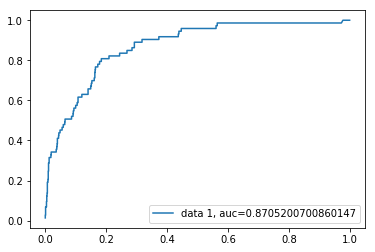

In [63]:
#get logreg probability scores for each player playing over 72 games in NHL
predict_gp = logreggames.predict(X_test_gp)
y_pred_proba_gp =  logreggames.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9204631993907629


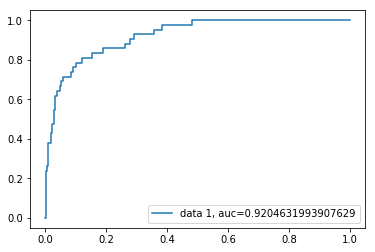

In [64]:
#get logreg probability scores for each player scoring over .42 pts per game in NHL
predict_pts = logregpoints.predict(X_test_pts)
y_pred_proba_pts =  logregpoints.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [65]:
confusion_matrix(y_test_gp, predict_gp)

array([[864, 168],
       [ 19,  54]], dtype=int64)

In [66]:
confusion_matrix(y_test_pts, predict_pts)

array([[863, 200],
       [  7,  35]], dtype=int64)

In [67]:
from sklearn.naive_bayes import GaussianNB
gnb_pts = GaussianNB()
gnb_gp = GaussianNB()
gnb_pts.fit(X_train_pts, y_train_pts)
gnb_gp.fit(X_train_gp, y_train_gp)
gnb_pts_pred = gnb.predict(X_test_pts)
gnb_gp_pred = gnb.predict(X_test_gp)


In [68]:
confusion_matrix(y_test_gp, gnb_gp_pred)

array([[702, 330],
       [ 11,  62]], dtype=int64)

In [69]:
confusion_matrix(y_test_pts, gnb_pts_pred)

array([[683, 380],
       [  9,  33]], dtype=int64)

0.8093806413932249


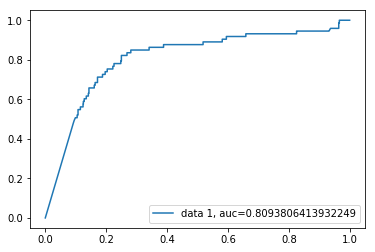

In [70]:
#get GNB probability scores for each player playing over 72 games in NHL
gnb_gp_pred = gnb.predict(X_test_gp)
y_pred_proba_gp = gnb.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7630358822738879


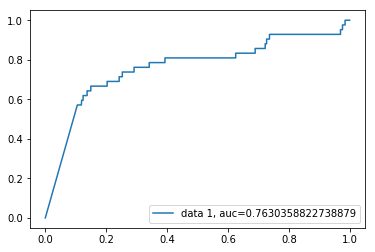

In [71]:
#get GNB probability scores for each player scoring over .42 points per games in NHL
gnb_pts_pred = gnb.predict(X_test_pts)
y_pred_proba_pts = gnb.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [87]:
tree_pts = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced')

tree_gp = RandomForest(n_jobs= -1, n_estimators= 500,
                       #warm_start= True, 
                       #'max_features': 0.2,
                       max_depth= 6, min_samples_leaf= 2, max_features = 'sqrt',
                       verbose=0, class_weight='balanced')

tree_pts.fit(X_train_pts, y_train_pts)
tree_gp.fit(X_train_gp, y_train_gp)
tree_pts_pred = gnb.predict(X_test_pts)
tree_gp_pred = gnb.predict(X_test_gp)

In [88]:
confusion_matrix(y_test_gp, tree_gp_pred)

array([[702, 330],
       [ 11,  62]], dtype=int64)

In [89]:
confusion_matrix(y_test_pts, tree_pts_pred)

array([[683, 380],
       [  9,  33]], dtype=int64)

0.8471912498672612


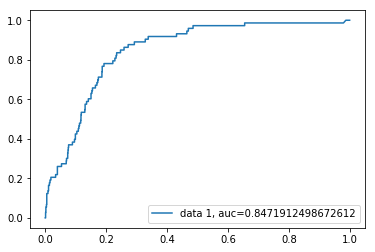

In [90]:
#get Random Forest probability scores for each forward playing over 72 games in NHL
tree_gp_pred = tree.predict(X_test_gp)
y_pred_proba_gp = tree.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8131859517089997


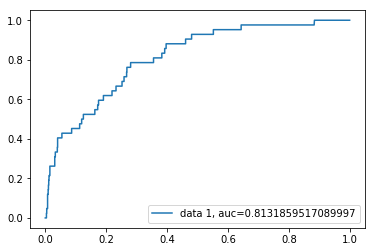

In [91]:
#get Random Forest probability scores for each forward scoring over .42 points per games in NHL
tree_pts_pred = tree.predict(X_test_pts)
y_pred_proba_pts = tree.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [77]:
from sklearn.tree import DecisionTreeClassifier

dt_pts = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts.fit(X_train_pts, y_train_pts)
dt_gp.fit(X_train_gp, y_train_gp)
dt_pred_pts = dt.predict(X_test_pts)
dt_pred_gp = dt.predict(X_test_gp)


In [78]:
confusion_matrix(y_test_pts, dt_pred_pts)

array([[570, 493],
       [  5,  37]], dtype=int64)

In [79]:
confusion_matrix(y_test_gp, dt_pred_gp)

array([[586, 446],
       [  2,  71]], dtype=int64)

0.7855793709452246


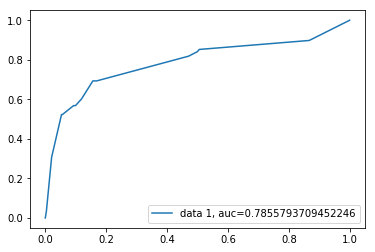

In [162]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_gp = dt_gp.predict(X_test_gp)
y_pred_prob_dt_gp =  dt_gp.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_dt_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_dt_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7485413495687467


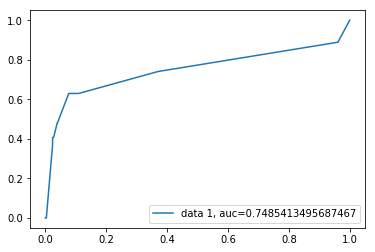

In [163]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_pts = dt_pts.predict(X_test_pts)
y_pred_prob_dt_pts =  dt_pts.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_dt_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_dt_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [92]:
#calculate SVM prediction probabilities
predictions = dt_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_dt'] = predictions_2018

In [93]:
#calculate random forest prediction probabilities
predictions = tree_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_tree'] = predictions_2018




In [94]:
#calculate random forest prediction probabilities
predictions = gnb_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_gnb'] = predictions_2018


In [95]:
#calculate random forest prediction probabilities
predictions = logreggames.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logreggames.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_log'] = predictions_2018

In [96]:
#calculate SVM prediction probabilities
predictions = dt_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_dt'] = predictions_2018

#calculate random forest prediction probabilities
predictions = tree_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_tree'] = predictions_2018




#calculate random forest prediction probabilities
predictions = gnb_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions_2018


#calculate random forest prediction probabilities
predictions = logregpoints.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logregpoints.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_log'] = predictions_2018

In [97]:
draft_2018_df_fwd['model_average_gp'] = draft_2018_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_2018_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
5478,Andrei Svechnikov,0.993316,1.000000,0.886792,0.964604,0.961178
32595,Filip Zadina,0.943873,1.000000,0.917316,0.964604,0.956448
81375,Oliver Wahlstrom,0.996753,1.000000,0.814570,0.964604,0.943982
48097,Joel Farabee,0.985815,0.992656,0.817063,0.964604,0.940034
1416,Aidan Dudas,0.906958,0.999789,0.860140,0.941090,0.926994
92763,Ryan McLeod,0.866790,0.997934,0.863747,0.941090,0.917390
9390,Barrett Hayton,0.899579,1.000000,0.823004,0.941090,0.915918
1579,Akil Thomas,0.946500,1.000000,0.775328,0.941090,0.915730
52688,Joseph Veleno,0.846633,1.000000,0.782943,0.964604,0.898545
32446,Filip Hållander,0.964438,0.955750,0.703008,0.968891,0.898022


In [98]:
draft_2018_df_fwd['model_average_pts'] = draft_2018_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_2018_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
32595,Filip Zadina,0.943873,1.000000,0.913051,0.962008,0.954733
5478,Andrei Svechnikov,0.993316,1.000000,0.792754,0.962008,0.937019
81375,Oliver Wahlstrom,0.996753,0.999995,0.736916,0.962008,0.923918
1579,Akil Thomas,0.946500,1.000000,0.681033,0.962008,0.897385
48097,Joel Farabee,0.985815,0.875788,0.743062,0.962008,0.891668
52688,Joseph Veleno,0.846633,1.000000,0.641776,0.962008,0.862604
39271,Jacob Olofsson,0.976767,0.996166,0.509799,0.927458,0.852548
1416,Aidan Dudas,0.906958,0.994716,0.659893,0.841129,0.850674
9390,Barrett Hayton,0.899579,1.000000,0.615849,0.841129,0.839139
92763,Ryan McLeod,0.866790,0.951289,0.637652,0.841129,0.824215


In [99]:
draft_df_fwd.columns

Index(['Player', 'Age', 'Position', 'Birthdate', 'HT', 'WT', 'season',
       'season_start', 'draft_cutoff', 'draft_cutoff_age', 'draft_year',
       'player_id', 'team_id', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',
       'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-',
       'goals_to_points', 'assists_to_points', 'pts_per_gp', 'nhl_GP', 'nhl_G',
       'nhl_A', 'nhl_TP', 'age_adj_pts_g', 'nhl_pts_per_gp',
       'league_Allsvenskan', 'league_Extraliga', 'league_KHL', 'league_Liiga',
       'league_Mestis', 'league_NCAA', 'league_OHL', 'league_QMJHL',
       'league_SHL', 'league_USDP', 'league_USHL', 'league_WHL', '>_72_nhl_gp',
       '>_.42_nhl_pts_gp', '>_72_nhl_gp_game_dt', '>_72_nhl_gp_game_tree',
       '>_72_nhl_gp_game_gnb', '>_72_nhl_gp_game_log', '>_.42_nhl_pts_game_dt',
       '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_gnb',
       '>_.42_nhl_pts_game_log'],
      dtype='object')

In [100]:
draft_rankings_2018_fwd = draft_2018_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [101]:
draft_rankings_2018_fwd = draft_rankings_2018_fwd.reset_index(drop=True)
draft_rankings_2018_fwd.index = np.arange(1,len(draft_rankings_2018_fwd)+1)
draft_rankings_2018_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Filip Zadina,0.954733,0.956448
2,Andrei Svechnikov,0.937019,0.961178
3,Akil Thomas,0.897385,0.915730
4,Joseph Veleno,0.862604,0.898545
5,Jacob Olofsson,0.852548,0.670800
6,Aidan Dudas,0.850674,0.926994
7,Barrett Hayton,0.839139,0.915918
8,Oliver Wahlstrom,0.828724,0.885459
9,Ryan McLeod,0.824215,0.917390
10,Martin Kaut,0.800072,0.688126


In [102]:
draft_df_fwd['model_average_pts'] = draft_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
100396,Taylor Hall,0.999492,1.0,0.977108,0.962008,0.984652
83368,Patrick Kane,0.999797,1.0,0.974472,0.962008,0.984069
97262,Sidney Crosby,0.999923,1.0,0.969877,0.962008,0.982952
21464,Connor McDavid,0.999968,1.0,0.969243,0.962008,0.982805
50730,Jonathan Drouin,0.998703,1.0,0.969149,0.962008,0.982465
15375,Bryan Little,0.995222,1.0,0.965480,0.962008,0.980677
77235,Mitchell Marner,0.999153,1.0,0.960929,0.962008,0.980522
70478,Matthew Tkachuk,0.999661,1.0,0.958699,0.962008,0.980092
31201,Eric Staal,0.992235,1.0,0.965973,0.962008,0.980054
71048,Max Domi,0.990046,1.0,0.967845,0.962008,0.979975


In [103]:
draft_df_fwd['model_average_gp'] = draft_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
100396,Taylor Hall,0.999492,1.0,0.979027,0.964604,0.985781
83368,Patrick Kane,0.999797,1.0,0.976783,0.964604,0.985296
70478,Matthew Tkachuk,0.999661,1.0,0.972565,0.964604,0.984207
50730,Jonathan Drouin,0.998703,1.0,0.969818,0.964604,0.983281
90020,Robby Fabbri,0.997228,1.0,0.967380,0.964604,0.982303
93828,Sam Gagner,0.999306,1.0,0.964755,0.964604,0.982166
21464,Connor McDavid,0.999968,1.0,0.961715,0.964604,0.981572
77825,Nathan MacKinnon,0.996130,1.0,0.962085,0.964604,0.980705
97262,Sidney Crosby,0.999923,1.0,0.952202,0.964604,0.979182
71048,Max Domi,0.990046,1.0,0.960532,0.964604,0.978796


In [104]:
draft_rankings_fwd = draft_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [106]:
draft_rankings_fwd = draft_rankings_fwd.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)


,Player,model_average_pts,model_average_gp
1,Taylor Hall,0.984652,0.985781
2,Patrick Kane,0.984069,0.985296
3,Sidney Crosby,0.982952,0.979182
4,Connor McDavid,0.982805,0.981572
5,Jonathan Drouin,0.982465,0.983281
6,Bryan Little,0.980677,0.975579
7,Mitchell Marner,0.980522,0.977766
8,Matthew Tkachuk,0.980092,0.984207
9,Eric Staal,0.980054,0.974151
10,Max Domi,0.979975,0.978796


In [236]:
draft_df_fwd.tail()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp,>_.42_nhl_pts_gp,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average_pts,model_average_gp
94265,21,Joël Caron,17.37,C/RW,1996-05-01,"Repentigny, QC, CAN",5.5,172,R,187371,10195,2014,Blainville-Boisbriand Armada,2013-09-15,2014-09-15,18.374,0,6,1,0,1,4,2,0,0,0,2,-1,1.0,0.0,0.17,0.0,0.0,0,0.0,0.164087,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.071240,0.050717,0.097369,4.536094e-11,0.019651,2.818963e-14,0.019651,0.041934,0.022723
91924,0,David Duhamel,17.84,C,1991-11-14,"Sherbrooke, QC, CAN",5.75,148,L,37091,882,2010,Baie-Comeau Drakkar,2009-09-15,2010-09-15,18.836,0,5,1,0,1,7,0,0,0,0,0,0,1.0,0.0,0.20,0.0,0.0,0,0.0,0.184208,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.069550,0.050717,0.085538,3.965395e-11,0.021157,2.474982e-14,0.021157,0.039353,0.022677
90231,34,Jean-Simon Legros,17.01,LW,1989-09-12,"Repentigny, QC, CAN",6.08,3227,L,55101,881,2007,Acadie-Bathurst Titan,2006-09-15,2007-09-15,18.007,0,7,0,0,0,19,2,0,0,0,2,0,0.0,0.0,0.00,0.0,0.0,0,0.0,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.035467,0.046320,0.050717,0.045443,3.868463e-10,0.006927,4.688219e-13,0.006927,0.025772,0.022179
95550,0,Jean-Simon Bélanger,17.54,RW,1998-03-03,"St-Félicien, QC, CAN",5.92,183,R,256560,533,2016,Chicoutimi Saguenéens,2015-09-15,2016-09-15,18.538,0,6,1,0,1,0,0,0,0,0,0,0,1.0,0.0,0.17,0.0,0.0,0,0.0,0.161371,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.066961,0.050717,0.065535,4.177588e-11,0.019822,2.559747e-14,0.019822,0.034019,0.021696
91541,11,Nick Huard,17.47,C,1991-03-29,"Sudbury, ON, CAN",5.75,181,L,32880,886,2009,Lewiston MAINEiacs,2008-09-15,2009-09-15,18.467,0,31,0,3,3,8,4,0,0,0,8,-4,0.0,1.0,0.10,0.0,0.0,0,0.0,0.095582,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.057854,0.050717,0.060398,1.417893e-07,0.022988,2.111726e-10,0.022988,0.033526,0.020210


In [219]:
draft_2018_df_fwd.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average,model_average_gp,model_average_pts
87647,14,Andrei Svechnikov,17.47,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.472,0,44,40,32,72,67,8,5,6,11,12,-1,0.56,0.44,1.64,0.0,0.0,0,0.0,1.567545,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0.942813,0.888051,0.967336,0.779691,1.000000,0.988396,1.000000,0.988397,0.954815,0.954815,0.933856
103286,18,Oliver Wahlstrom,17.26,C/RW,2000-06-13,"Yarmouth, ME, USA",6.08,205,R,241370,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.256,0,62,48,46,94,42,0,0,0,0,0,0,0.51,0.49,1.52,0.0,0.0,0,0.0,1.482851,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.825256,0.967336,0.786628,1.000000,0.997271,0.999995,0.997271,0.941335,0.941335,0.937807
96834,11,Filip Zadina,17.80,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.801,0,57,44,38,82,36,9,5,7,12,0,2,0.54,0.46,1.44,0.0,0.0,0,0.0,1.331712,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.942813,0.890255,0.967336,0.878163,1.000000,0.928457,1.000000,0.928458,0.940381,0.940381,0.943489
103269,28,Joel Farabee,17.56,LW,2000-02-25,"Cicero, NY, USA",6,168,L,334036,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.554,0,62,33,43,76,44,0,0,0,0,0,0,0.43,0.57,1.23,0.0,0.0,0,0.0,1.165253,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.829568,0.967336,0.830511,0.999943,0.986693,0.880039,0.986693,0.939754,0.939754,0.916145
110221,18,Jack Drury,17.62,C,2000-02-03,"Winnetka, IL, USA",5.92,179,L,283916,907,2018,Waterloo Black Hawks,2017-09-15,2018-09-15,18.615,0,56,24,41,65,83,6,3,1,4,2,2,0.37,0.63,1.16,0.0,0.0,0,0.0,1.092395,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.942813,0.838905,0.967336,0.633906,0.999597,0.928022,0.480779,0.928022,0.927334,0.927334,0.752511


In [238]:
draft_rankings = draft_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].\
groupby(['Player'], as_index=False).mean().sort_values(['model_average_pts'], ascending=False)

In [240]:
draft_rankings_fwd = draft_rankings.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Taylor Hall,0.985790,0.976882
2,Matthew Tkachuk,0.984151,0.973069
3,Jonathan Drouin,0.983501,0.973543
4,Bryan Little,0.983169,0.972554
5,Connor McDavid,0.982999,0.977701
6,Sidney Crosby,0.981887,0.974326
7,Nathan MacKinnon,0.981258,0.970142
8,Patrick Kane,0.981226,0.976740
9,Nick Suzuki,0.980861,0.965398
10,Alex DeBrincat,0.980651,0.966747


In [109]:
draft_rankings_fwd[draft_rankings_fwd['Player']=='Alexander Ovechkin']

,Player,model_average_pts,model_average_gp


In [116]:
roster[(roster['team'] == 'Dynamo Moskva') & (roster['season'] == 2009)]

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team
38761,20,Mikhail Biryukov,32,G,1985-10-13,"Yaroslavl, RUS","6'0""",198,L,14598,6815,2009,Dynamo Moskva
38762,42,Andrei Malkov,45,G,1973-04-29,"Kirovo-Chepetsk, RUS","5'11""",192,L,14599,6815,2009,Dynamo Moskva
38763,46,Alexander Sharychenkov,26,G,1991-10-03,"Nizhny Novgorod, RUS","6'4""",207,L,50657,6815,2009,Dynamo Moskva
38764,31,Vitali Yeremeyev,42,G,1975-09-23,"Ust-Kamenogorsk, KAZ","6'0""",203,L,14581,6815,2009,Dynamo Moskva
38765,90,Alexander Zalivin,27,G,1990-07-15,"Moskva, RUS","6'0""",196,L,98308,6815,2009,Dynamo Moskva
38766,39,Vadim Zhelobnyuk,29,G,1989-04-22,"Moskva, RUS","6'0""",203,L,11874,6815,2009,Dynamo Moskva
38767,35,Alexander Budkin,31,D,1986-09-08,"Chelyabinsk, RUS","6'5""",212,R,18547,6815,2009,Dynamo Moskva
38768,6,Denis Denisov,36,D,1981-12-31,"Kharkov, UKR","6'0""",190,L,9556,6815,2009,Dynamo Moskva
38769,25,Igor Golovkov,27,D,1990-05-17,"Moskva, RUS","6'4""",209,L,17573,6815,2009,Dynamo Moskva
38770,83,Maxim Isayev,29,D,1989-03-21,"Moskva, RUS","6'2""",203,L,24177,6815,2009,Dynamo Moskva
